In [1]:
import pandas as pd
import time
import spacy
import numpy as np
from datetime import datetime, timezone
import pytz  
import tzlocal
from dateutil import tz
import re
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from collections import defaultdict
from backports.zoneinfo import ZoneInfo
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from os import path

# stopwords, tokenizer, stemmer
import nltk  
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import RSLPStemmer
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# data visualization
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.express as px
import seaborn as sns
from matplotlib import rcParams
import matplotlib.ticker as ticker

In [2]:
df = pd.read_csv("base2_anotada.csv", encoding='UTF-8')

In [3]:
df.shape

(9605, 9)

In [4]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Tweet_ID,Sentiment,Tweet_Text,Created_at,Tweet_Geo,User_Name,User_Location
0,0,252278,1.503750e+18,neutro,"minha gente, em minha última live abri o coraç...",2022-03-15 14:52:24+00:00,NaN,Emanuel Pinheiro,"Cuiabá, MT"
1,1,157301,1.539940e+18,negativo,"👇👇👇👇👇👇👇👇 ""a suprema corte brasileira planeja c...",2022-06-23 12:02:56+00:00,NaN,Maria Paula,Brasil
2,2,203491,1.522780e+18,neutro,guerra cultural e as eleições de outubro https...,2022-05-07 03:10:38+00:00,NaN,🎗Dilma Resistente,NaN
3,3,263418,1.496420e+18,neutro,"eleições 2022. federações, uma aposta incerta...",2022-02-23 09:37:08+00:00,NaN,Pedro Luiz,OLINDA
4,4,140421,1.545780e+18,positivo,"um assunto nacional do brasil, não tem que se ...",2022-07-09 14:36:02+00:00,NaN,🇧🇷 Robson Barros 🇧🇷 ( 3.42k ) 🇧🇷,"Teresina, Piaui Brasil"


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9605 entries, 0 to 9604
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0.1   9605 non-null   int64  
 1   Unnamed: 0     9605 non-null   int64  
 2   Tweet_ID       9605 non-null   float64
 3   Sentiment      9605 non-null   object 
 4   Tweet_Text     9605 non-null   object 
 5   Created_at     9605 non-null   object 
 6   Tweet_Geo      259 non-null    object 
 7   User_Name      9600 non-null   object 
 8   User_Location  6667 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 675.5+ KB


## Pré-processamento

In [6]:
nlp = spacy.load('pt_core_news_lg')
def preprocess(df):
    stop_words = stopwords.words('portuguese')
    new_stopwords= ['q','pro', 'pra','tar','ter', 'pq', 'aí', 'então', 'porque', 'ir', 'vc', 'tá', 'd', 'sobre', 
                    'prá', 'todo', 'vir' ]
    stop_words.extend(new_stopwords)
    st = RSLPStemmer()
    
    #df['Tweet_Text'] = str(df['Tweet_Text'])
    
    df['Tweet_Text'].dropna(inplace=True)

    #Remove nome de usuários (está diminuindo a precisão)
    df['Tweet_Text'] = [re.sub('@[^\s]+','', entry) for entry in df['Tweet_Text']]

    # Remove @RT de retweets
    df['Tweet_Text'] = [re.sub(r'^RT[\s]+', '', entry) for entry in df['Tweet_Text']]

    # Remove hiperlinks
    df['Tweet_Text'] = [re.sub(r'https?:\/\/.*[\r\n]*', '', entry) for entry in df['Tweet_Text']]
    
    #Lemetizacao
    df["Tweet_Text"] = df['Tweet_Text'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x)]))
    
    #stemming
    #df["Tweet_Text"] = df['Tweet_Text'].apply(lambda x: " ".join([st.stem(word) for word in df['Tweet_Text']]))
    
    # Padroniza todo o texto em caixa baixa (letras minúsculas)
    df['Tweet_Text'] = [entry.lower() for entry in df['Tweet_Text']]
    
    #Remover stopwords
    df['Tweet_Text'] = df['Tweet_Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words) and word.isalpha()]))
    
    
    #Tokenização: Cada tweet é dividido em um array de palavras
    df['Tweet_Text']= [word_tokenize(entry) for entry in df['Tweet_Text']]
    
    #transformar tweet text em array de strings
    df['Text_Final']= [str(item) for item in df['Tweet_Text']]

    #Remove Z format
    date_column = []
    for datez in df['Created_at']:
        datez= (datez.split("+", 1))[0]
        date_column.append(datez)
    df['Created_at'] = date_column
    
    #convert timezone

    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz("America/Sao_Paulo")
    local = []
    for date in df['Created_at']:
        date = datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
        date = date.replace(tzinfo=from_zone)
        # Convert time zone
        date = date.astimezone(to_zone)
        local.append(date)

    df['Created_at'] = local
    
    #separate column date to date and time
    df['Date_Created'] = pd.to_datetime(df['Created_at']).dt.date
    df['Time_Created'] = pd.to_datetime(df['Created_at']).dt.time
    
 

In [7]:
preprocess(df)

In [8]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Tweet_ID,Sentiment,Tweet_Text,Created_at,Tweet_Geo,User_Name,User_Location,Text_Final,Date_Created,Time_Created
0,0,252278,1.503750e+18,neutro,"[gente, último, live, abrir, coração, falar, e...",2022-03-15 11:52:24-03:00,NaN,Emanuel Pinheiro,"Cuiabá, MT","['gente', 'último', 'live', 'abrir', 'coração'...",2022-03-15,11:52:24
1,1,157301,1.539940e+18,negativo,"[supremo, corte, brasileiro, planejar, coopera...",2022-06-23 09:02:56-03:00,NaN,Maria Paula,Brasil,"['supremo', 'corte', 'brasileiro', 'planejar',...",2022-06-23,09:02:56
2,2,203491,1.522780e+18,neutro,"[guerra, cultural, eleição, outubro]",2022-05-07 00:10:38-03:00,NaN,🎗Dilma Resistente,NaN,"['guerra', 'cultural', 'eleição', 'outubro']",2022-05-07,00:10:38
3,3,263418,1.496420e+18,neutro,"[eleição, federação, aposta, incerto]",2022-02-23 06:37:08-03:00,NaN,Pedro Luiz,OLINDA,"['eleição', 'federação', 'aposta', 'incerto']",2022-02-23,06:37:08
4,4,140421,1.545780e+18,positivo,"[assunto, nacional, brasil, discutir, paris, n...",2022-07-09 11:36:02-03:00,NaN,🇧🇷 Robson Barros 🇧🇷 ( 3.42k ) 🇧🇷,"Teresina, Piaui Brasil","['assunto', 'nacional', 'brasil', 'discutir', ...",2022-07-09,11:36:02


## Treinamento dos Modelos - Selecao do melhor modelo por TF-idf e Word2vec

In [9]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['Text_Final'],df['Sentiment'],test_size=0.2, stratify = df['Sentiment'], random_state=42)

Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

#Padrões TF-IDF
Tfidf_vect = TfidfVectorizer(max_features=10000)
Tfidf_vect.fit(df['Text_Final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

#print(Tfidf_vect.vocabulary_)

#print(Train_X_Tfidf)

In [10]:
#função calcular acurácia por Cross Validation
def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média esperada pelo cross validation : {:.2f}%'.format(mean*100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'
           .format((mean - 2*dv)*100, (mean + 2*dv)*100))
    print ('-----------------------------------------')

In [11]:
# ajustar o conjunto de dados de treinamento no classificador NB

#treinar o modelo e calcular acurácia media esperada pelo Cross Validation
cv = StratifiedKFold(n_splits = 5, shuffle = True)
model = naive_bayes.MultinomialNB()
results = cross_val_score(model, Train_X_Tfidf, Train_Y, cv = cv)
intervalo(results)


Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# prever os rótulos no conjunto de dados de validação
predictions_NB = Naive.predict(Test_X_Tfidf)


#imprimir na tela a acurácia, f-measure, precisão e recall
print("Naive Bayes Accuracy: ",accuracy_score(predictions_NB, Test_Y)*100)
print("Naive Bayes F-Measure: ",f1_score(predictions_NB, Test_Y, average="macro")*100)
print("Naive Bayes Precision: ",precision_score(predictions_NB, Test_Y, average="macro")*100)
print("Naive Bayes Recall: ",recall_score(predictions_NB, Test_Y, average="macro")*100)

Acurácia média esperada pelo cross validation : 90.79%
Intervalo de acurácia: [90.68% ~ 90.89%]
-----------------------------------------
Naive Bayes Accuracy:  90.83810515356585
Naive Bayes F-Measure:  32.76488610592481
Naive Bayes Precision:  33.843320712586774
Naive Bayes Recall:  52.51419302514192


/Users/maiaracandido/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
# Classificador SVM

#treinar o modelo e calcular acurácia media esperada pelo Cross Validation
cv = StratifiedKFold(n_splits = 5, shuffle = True)
model = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
results = cross_val_score(model, Train_X_Tfidf, Train_Y, cv = cv)
intervalo(results)

# ajustar o conjunto de dados de treinamento no classificador SVM
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
#SVM = svm.SVC(C=1.0, kernel='rbf', degree=3, gamma=1)
#'C': 10, 'gamma': 1, 'kernel': 'rbf'
SVM.fit(Train_X_Tfidf,Train_Y)
# prever os rótulos no conjunto de dados de validação
predictions_SVM = SVM.predict(Test_X_Tfidf)
#imprimir na tela a acurácia, f-measure, precisão e recall
print("SVM Accuracy: ",accuracy_score(predictions_SVM, Test_Y)*100)
print("SVM F-Measure: ",f1_score(predictions_SVM, Test_Y, average="macro")*100)
print("SVM Precision: ",precision_score(predictions_SVM, Test_Y, average="macro")*100)
print("SVM Recall: ",recall_score(predictions_SVM, Test_Y, average="macro")*100)

Acurácia média esperada pelo cross validation : 91.11%
Intervalo de acurácia: [90.79% ~ 91.44%]
-----------------------------------------
SVM Accuracy:  91.25455491931285
SVM F-Measure:  37.9128961370973
SVM Precision:  36.594204450383614
SVM Recall:  91.54437456324249


In [13]:
#Tunar Hiperparametros SVM

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001, 'auto'],'kernel': ['linear','rbf', 'poly', 'sigmoid']}

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(Train_X_Tfidf,Train_Y)


Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   1.6s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   1.6s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   1.6s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   1.6s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   1.6s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.2s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   4.6s
[CV] END ........................C=0.1, gamma=1

[CV] END ........................C=1, gamma=1, kernel=linear; total time=   1.7s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   1.6s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   1.6s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   1.6s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   3.2s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   3.3s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   3.2s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   3.2s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   3.5s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=   5.8s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=   5.6s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=   5.6s
[CV] END ...................

[CV] END .......................C=10, gamma=1, kernel=linear; total time=   1.6s
[CV] END .......................C=10, gamma=1, kernel=linear; total time=   1.7s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   3.9s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   3.9s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   3.9s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   3.9s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   4.0s
[CV] END .........................C=10, gamma=1, kernel=poly; total time=   6.6s
[CV] END .........................C=10, gamma=1, kernel=poly; total time=   6.2s
[CV] END .........................C=10, gamma=1, kernel=poly; total time=   6.2s
[CV] END .........................C=10, gamma=1, kernel=poly; total time=   6.5s
[CV] END .........................C=10, gamma=1, kernel=poly; total time=   6.2s
[CV] END ...................

[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   4.0s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   3.9s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   3.9s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   3.9s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   4.0s
[CV] END ........................C=100, gamma=1, kernel=poly; total time=   6.2s
[CV] END ........................C=100, gamma=1, kernel=poly; total time=   6.5s
[CV] END ........................C=100, gamma=1, kernel=poly; total time=   6.2s
[CV] END ........................C=100, gamma=1, kernel=poly; total time=   6.5s
[CV] END ........................C=100, gamma=1, kernel=poly; total time=   6.8s
[CV] END .....................C=100, gamma=1, kernel=sigmoid; total time=   2.5s
[CV] END .....................C=100, gamma=1, kernel=sigmoid; total time=   1.4s
[CV] END ...................

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001, 'auto'],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             verbose=2)

In [14]:

# print best parameter after tuning
print(grid.best_estimator_)
print(grid.best_params_)

SVC(C=10, gamma=0.1)
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [15]:
#final model SVM

#treinar o modelo e calcular acurácia media esperada pelo Cross Validation
cv = StratifiedKFold(n_splits = 5, shuffle = True)
model = svm.SVC(C=10, kernel='rbf', gamma=0.1)
results = cross_val_score(model, Train_X_Tfidf, Train_Y, cv = cv)
intervalo(results)


# prever os rótulos no conjunto de dados de validação
predictions_SVM = grid.predict(Test_X_Tfidf)
#imprimir na tela a acurácia, f-measure, precisão e recall
print("SVM Accuracy: ",accuracy_score(predictions_SVM, Test_Y)*100)
print("SVM F-Measure: ",f1_score(predictions_SVM, Test_Y, average="macro")*100)
print("SVM Precision: ",precision_score(predictions_SVM, Test_Y, average="macro")*100)
print("SVM Recall: ",recall_score(predictions_SVM, Test_Y, average="macro")*100)


Acurácia média esperada pelo cross validation : 91.33%
Intervalo de acurácia: [90.59% ~ 92.08%]
-----------------------------------------
SVM Accuracy:  91.51483602290473
SVM F-Measure:  48.8752153427193
SVM Precision:  43.78917214184349
SVM Recall:  75.92152717323715


In [16]:
# Fitting a random forest classifier to the training data

#treinar o modelo e calcular acurácia media esperada pelo Cross Validation
cv = StratifiedKFold(n_splits = 5, shuffle = True)
model = RandomForestClassifier(n_estimators = 100)
results = cross_val_score(model, Train_X_Tfidf, Train_Y, cv = cv)
intervalo(results)


forest = RandomForestClassifier(n_estimators = 100)
    
print("Fitting random forest to training data....")    
forest = forest.fit(Train_X_Tfidf,Train_Y)
# prever os rótulos no conjunto de dados de validação
result = forest.predict(Test_X_Tfidf)
#imprimir na tela a acurácia, f-measure, precisão e recall
print("Accuracy: ",accuracy_score(result, Test_Y)*100)
print("F-Measure: ",f1_score(result, Test_Y, average="macro")*100)
print("Precision: ",precision_score(result, Test_Y, average="macro")*100)
print("Recall: ",recall_score(result, Test_Y, average="macro")*100)


Acurácia média esperada pelo cross validation : 91.25%
Intervalo de acurácia: [91.04% ~ 91.47%]
-----------------------------------------
Fitting random forest to training data....
Accuracy:  91.09838625715773
F-Measure:  40.428413557012405
Precision:  37.949435635620205
Recall:  82.8241123038811


In [17]:
#Turnar Hiperparametros Random Forest
param_grid = {
'n_estimators': [50, 100, 200, 300],
'min_samples_leaf': [1, 5, 10],
'bootstrap': [True, False]}

grid2 = GridSearchCV(RandomForestClassifier(),param_grid,refit=True,verbose=2)
grid2.fit(Train_X_Tfidf,Train_Y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=50; total time=   4.9s
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=50; total time=   4.8s
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=50; total time=   4.8s
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=50; total time=   4.9s
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=50; total time=   4.7s
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=100; total time=   9.6s
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=100; total time=   9.6s
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=100; total time=   9.5s
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=100; total time=   9.6s
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=100; total time=   9.4s
[CV] END bootstrap=True, min_samples_leaf=1, n_estimators=200; total time=  19.4s
[CV] END bootstrap=True, min_samples_leaf

[CV] END bootstrap=False, min_samples_leaf=5, n_estimators=300; total time=  22.4s
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=50; total time=   2.2s
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=50; total time=   2.2s
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=50; total time=   2.2s
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=50; total time=   2.3s
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=50; total time=   2.2s
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=100; total time=   4.4s
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=100; total time=   4.6s
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=100; total time=   4.4s
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=100; total time=   4.4s
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=100; total time=   4.5s
[CV] END bootstrap=False, min_samples_leaf=10, n_estimators=200; total time=   8.7

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'min_samples_leaf': [1, 5, 10],
                         'n_estimators': [50, 100, 200, 300]},
             verbose=2)

In [18]:
# print best parameter after tuning
print(grid2.best_estimator_)
print(grid2.best_params_)

RandomForestClassifier()
{'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 100}


In [19]:
# prever os rótulos no conjunto de dados de validação
predictions_rf = grid2.predict(Test_X_Tfidf)
#imprimir na tela a acurácia, f-measure, precisão e recall
print("RF Accuracy: ",accuracy_score(predictions_rf, Test_Y)*100)
print("RF F-Measure: ",f1_score(predictions_rf, Test_Y, average="macro")*100)
print("RF Precision: ",precision_score(predictions_rf, Test_Y, average="macro")*100)
print("RF Recall: ",recall_score(predictions_rf, Test_Y, average="macro")*100)


RF Accuracy:  91.20249869859448
RF F-Measure:  41.33115774917201
RF Precision:  38.47853616472073
RF Recall:  84.6418551639488


In [20]:
# ajustar o conjunto de dados de treinamento Extreme Gradient Boosting

#treinar o modelo e calcular acurácia media esperada pelo Cross Validation
# cv = StratifiedKFold(n_splits = 5, shuffle = True)
# model =  XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3)
# results = cross_val_score(model, Train_X_Tfidf, Train_Y, cv = cv)
# intervalo(results)

# xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3)
# xgb.fit(Train_X_Tfidf,Train_Y) 
# prediction = xgb.predict(Test_X_Tfidf)

# #imprimir na tela a acurácia, f-measure, precisão e recall
# print("XGBoost Accuracy: ",accuracy_score(prediction, Test_Y)*100)
# print("XGBoost F-Measure: ",f1_score(prediction, Test_Y, average="macro")*100)
# print("XGBoost Precision: ",precision_score(prediction, Test_Y, average="macro")*100)
# print("XGBoost Recall: ",recall_score(prediction, Test_Y, average="macro")*100)

## Word2Vec

In [21]:
#Implementing word2vec

# Skip-gram model (sg = 1)
size = 1000
window = 3
min_count = 1
workers = 2
sg = 1

start_time = time.time()
stemmed_tokens = pd.Series(df['Tweet_Text']).values
# Train the Word2Vec Model
w2v_model = Word2Vec(stemmed_tokens, min_count = min_count, vector_size = size, workers = workers, window = window, sg = sg)

w2v_model.train (stemmed_tokens, total_examples= len(df['Tweet_Text']), epochs=20)


(1750626, 1954240)

In [22]:
# Load the model from the model file
words = list(w2v_model.wv.index_to_key)
print(words)


['eleição', 'candidato', 'brasil', 'tse', 'eleitoral', 'poder', 'dizer', 'fazer', 'dia', 'ano', 'presidente', 'governo', 'ver', 'voto', 'pesquisa', 'político', 'votar', 'novo', 'bom', 'urna', 'partido', 'saber', 'deputado', 'querer', 'candidatura', 'eleitor', 'pt', 'falar', 'brasileiro', 'dever', 'enquete', 'agora', 'campanha', 'força', 'país', 'grande', 'federal', 'estado', 'senado', 'vivo', 'debate', 'primeiro', 'hoje', 'outubro', 'dar', 'turno', 'contra', 'ainda', 'democracia', 'presidencial', 'ler', 'próximo', 'paulo', 'armar', 'governador', 'fake', 'povo', 'leia', 'stf', 'resultado', 'acabar', 'começar', 'defesa', 'ficar', 'outro', 'mundo', 'esquerda', 'estadual', 'rio', 'segundo', 'política', 'news', 'eletrônico', 'ministro', 'militar', 'justiça', 'pedir', 'público', 'pessoa', 'chegar', 'disputar', 'apoio', 'título', 'aqui', 'tudo', 'rede', 'legislativo', 'após', 'processo', 'prazo', 'bem', 'sp', 'notícia', 'presidência', 'moraes', 'tribunal', 'social', 'ganhar', 'informação', 's

In [23]:
#palavras com polaridade negativa
print(w2v_model.wv.most_similar(negative= ['eleição']))

[('derrete', 0.0669889897108078), ('servisau', 0.06092144921422005), ('tadim', 0.05570805445313454), ('sds', 0.015602298080921173), ('hehehe', 0.004981221165508032), ('explicado', -0.020927410572767258), ('ocupado', -0.02261560782790184), ('agrsncatolicas', -0.025064151734113693), ('maravilhar', -0.026513822376728058), ('partido', -0.0463232696056366)]


In [24]:
#calcular vetores
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += w2v_model.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [25]:
wordvec_arrays = np.zeros((len(df['Tweet_Text']), 1000)) 
for i in range(len(df['Tweet_Text'])):
    wordvec_arrays[i,:] = word_vector(df['Tweet_Text'][i], 1000)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(9605, 1000)

In [26]:
wordvec_df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.066835,-0.020353,0.046192,0.112186,0.036670,-0.056836,0.066693,0.051875,-0.028466,0.026597,...,-0.013939,-0.033570,0.116938,0.116980,0.094570,-0.000457,-0.052970,-0.119770,0.050005,-0.089608
1,0.082720,-0.014654,0.054180,0.070910,0.055843,-0.020088,0.054510,0.045630,0.006239,0.079977,...,0.017508,-0.071354,0.097605,0.092738,0.041451,-0.064108,-0.027174,-0.053889,0.036341,-0.074258
2,0.033875,0.037565,0.005450,0.114978,-0.004804,-0.062507,0.049682,0.113031,0.018883,0.065133,...,-0.026012,-0.064099,0.150727,0.139006,0.090653,0.079841,-0.047381,-0.014660,0.092636,-0.085558
3,0.062607,0.027698,0.033372,0.100789,0.049096,-0.093883,0.062454,0.084738,-0.028494,0.017027,...,0.039291,-0.054874,0.104359,0.094292,0.104129,0.019073,-0.125166,-0.189175,0.081657,-0.016379
4,0.070558,-0.006228,0.013740,0.140535,0.063872,-0.047584,0.034297,0.047278,0.027519,0.042307,...,-0.011904,-0.014179,0.110829,0.123883,0.064204,-0.025614,-0.084890,-0.125701,0.074656,-0.062543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9600,0.140803,-0.016231,0.104571,0.060857,-0.022531,-0.034885,0.044497,0.039329,-0.047522,0.011327,...,0.043028,-0.068178,0.123893,0.106764,0.193986,-0.059767,-0.194116,-0.125942,0.068040,-0.080373
9601,0.090072,0.022280,0.071614,0.041928,0.026351,-0.043778,0.076947,-0.006621,0.021966,0.018730,...,0.025920,-0.089915,0.143390,0.097984,0.199253,-0.024286,-0.069066,-0.108907,0.015067,-0.056332
9602,0.047268,0.023246,0.013448,0.123996,0.019069,-0.003332,0.110328,0.027220,-0.003847,-0.022015,...,-0.009870,-0.062375,0.128227,0.093058,0.117577,-0.001143,-0.042070,-0.071220,0.033494,-0.052349
9603,0.058331,0.059724,0.012189,0.073097,0.043760,-0.033196,0.085097,0.045794,-0.071548,0.007492,...,0.110476,-0.065412,0.086219,0.043795,0.062217,-0.050885,-0.045065,-0.129748,0.047293,-0.045297


In [27]:
Train_X_w2v, Test_X__w2v, Train_Y__w2v, Test_Y__w2v = model_selection.train_test_split(wordvec_df,df['Sentiment'],test_size=0.2, stratify = df['Sentiment'], random_state=42)

Encoder = LabelEncoder()
Train_Y__w2v = Encoder.fit_transform(Train_Y__w2v)
Test_Y__w2v = Encoder.fit_transform(Test_Y__w2v)

In [28]:
# Classificador SVM with word2vec

#treinar o modelo e calcular acurácia media esperada pelo Cross Validation
cv = StratifiedKFold(n_splits = 5, shuffle = True)
model = svm.SVC(C=10, kernel='rbf', gamma=0.1)
results = cross_val_score(model, Train_X_w2v, Train_Y__w2v, cv = cv)
intervalo(results)

# ajustar o conjunto de dados de treinamento no classificador SVM
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_w2v,Train_Y__w2v)
# prever os rótulos no conjunto de dados de validação
predictions_SVM = SVM.predict(Test_X__w2v)
#imprimir na tela a acurácia, f-measure, precisão e recall
print("SVM Accuracy: ",accuracy_score(predictions_SVM, Test_Y__w2v)*100)
print("SVM F-Measure: ",f1_score(predictions_SVM, Test_Y__w2v, average="macro")*100)
print("SVM Precision: ",precision_score(predictions_SVM, Test_Y__w2v, average="macro")*100)
print("SVM Recall: ",recall_score(predictions_SVM, Test_Y__w2v, average="macro")*100)

Acurácia média esperada pelo cross validation : 90.93%
Intervalo de acurácia: [90.63% ~ 91.23%]
-----------------------------------------
SVM Accuracy:  90.78604893284748
SVM F-Measure:  31.72351068667576
SVM Precision:  33.33333333333333
SVM Recall:  30.262016310949157


/Users/maiaracandido/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
# Fitting a random forest classifier to the training data with w2vec

#treinar o modelo e calcular acurácia media esperada pelo Cross Validation
cv = StratifiedKFold(n_splits = 5, shuffle = True)
model = RandomForestClassifier(n_estimators = 100)
results = cross_val_score(model, Train_X_w2v, Train_Y__w2v, cv = cv)
intervalo(results)



forest = RandomForestClassifier(bootstrap= True, min_samples_leaf= 1, n_estimators= 100)
    
print("Fitting random forest to training data....")    
forest = forest.fit(Train_X_w2v,Train_Y__w2v)
# prever os rótulos no conjunto de dados de validação
result = forest.predict(Test_X__w2v)
#imprimir na tela a acurácia, f-measure, precisão e recall
print("Accuracy: ",accuracy_score(result, Test_Y__w2v)*100)
print("F-Measure: ",f1_score(result, Test_Y__w2v, average="macro")*100)
print("Precision: ",precision_score(result, Test_Y__w2v, average="macro")*100)
print("Recall: ",recall_score(result, Test_Y__w2v, average="macro")*100)
    

Acurácia média esperada pelo cross validation : 91.15%
Intervalo de acurácia: [90.78% ~ 91.52%]
-----------------------------------------
Fitting random forest to training data....
Accuracy:  91.04633003643934
F-Measure:  40.44999881380259
Precision:  38.0739298777615
Recall:  74.23669467787116


In [30]:
# ajustar o conjunto de dados de treinamento no classificador NB with w2v


scaler = MinMaxScaler()
model=scaler.fit(Train_X_w2v)
Train_X_w2v_scale=model.transform(Train_X_w2v)
Test_X__w2v_scale = model.transform(Test_X__w2v)

#treinar o modelo e calcular acurácia media esperada pelo Cross Validation
cv = StratifiedKFold(n_splits = 5, shuffle = True)
model = naive_bayes.MultinomialNB()
results = cross_val_score(model, Train_X_w2v_scale, Train_Y__w2v, cv = cv)
intervalo(results)

Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_w2v_scale,Train_Y__w2v)
# prever os rótulos no conjunto de dados de validação
predictions_NB = Naive.predict(Test_X__w2v_scale)

#imprimir na tela a acurácia, f-measure, precisão e recall
print("Naive Bayes Accuracy: ",accuracy_score(predictions_NB, Test_Y__w2v)*100)
print("Naive Bayes F-Measure: ",f1_score(predictions_NB, Test_Y__w2v, average="macro")*100)
print("Naive Bayes Precision: ",precision_score(predictions_NB, Test_Y__w2v, average="macro")*100)
print("Naive Bayes Recall: ",recall_score(predictions_NB, Test_Y__w2v, average="macro")*100)

Acurácia média esperada pelo cross validation : 90.53%
Intervalo de acurácia: [90.11% ~ 90.94%]
-----------------------------------------
Naive Bayes Accuracy:  90.89016137428423
Naive Bayes F-Measure:  38.986483388459625
Naive Bayes Precision:  37.28027908411071
Naive Bayes Recall:  68.47454241266512


In [31]:
# ajustar o conjunto de dados de treinamento Extreme Gradient Boosting with w2v

#treinar o modelo e calcular acurácia media esperada pelo Cross Validation
# cv = StratifiedKFold(n_splits = 5, shuffle = True)
# model = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3)
# results = cross_val_score(model, Train_X_w2v, Train_Y__w2v, cv = cv)
# intervalo(results)

# xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(Train_X_w2v, Train_Y__w2v) 
# prediction = xgb.predict(Test_X__w2v)

# #imprimir na tela a acurácia, f-measure, precisão e recall
# print("XGBoost Accuracy: ",accuracy_score(prediction, Test_Y__w2v)*100)
# print("XGBoost F-Measure: ",f1_score(prediction, Test_Y__w2v, average="macro")*100)
# print("XGBoost Precision: ",precision_score(prediction, Test_Y__w2v, average="macro")*100)
# print("XGBoost Recall: ",recall_score(prediction, Test_Y__w2v, average="macro")*100)

## Classificação da Base

In [96]:
#Read data
#preprocess data
df_b = pd.read_csv("search_eleições 2022 -is:retweet lang:pt-Copy1.csv", encoding='UTF-8')
df_b.shape


(326488, 6)

In [97]:
#Eliminar tweets com nomes de candidatos 
df_b['Tweet_Text'] = [entry.lower() for entry in df_b['Tweet_Text']]
searchfor = ['bolsonaro', 'lula', 'ciro', 'simone', 'bozo', 'biroliro', 'jair', 'jair bolsonaro', 'ciro gomes', 'cirao', 'luiz felipe d’avila', 'felipe d’avila', 'felipe davila', 'vera lucia',
            'vera lúcia', 'sofia manzano', 'tebet', 'luis inacio', 'eymael', 'leonardo péricles', 'leonardo pericles',
            'soraya thronicke', 'pablo marçal', 'kelmon souza','doria', 'angola', 'moro', 'janones', 'acm', 'marconi', 'mourão', 
            'castro', 'raniery', 'lisboa', 'bolson4ro', 'bonoro', 'onyx', 'eleições portuguesas', 'haddad' 'vera salgado', 'tarcisio', 'haddad', 'marina silva', 'b0ls0nar0', 'portugal', 'angola']
df_b = df_b[~df_b.Tweet_Text.str.contains('|'.join(searchfor))]

#df_b = df_b[~(df_b['Created_at'] < '2022-01-01')]

In [98]:
df_b.shape

(198387, 6)

In [99]:
preprocess(df_b)

In [100]:
#Eliminar tweets anteriores a 01-01-2022
df_b = df_b[~(df_b['Created_at'] < '2022-01-01')]

In [101]:
df_b.tail()

,Tweet_ID,Tweet_Text,Created_at,Tweet_Geo,User_Name,User_Location,Text_Final,Date_Created,Time_Created
301202,1477112763751219206,"[feliz, ano, bom, oq, passar, esqueçam, show, ...",2022-01-01 00:01:40-03:00,NaN,ؘbigger than ju,Love Of My Life,"['feliz', 'ano', 'bom', 'oq', 'passar', 'esque...",2022-01-01,00:01:40
301203,1477112642997211137,"[feliz, ano, novo, twitterland, bom, fandom, c...",2022-01-01 00:01:12-03:00,NaN,🚩🌵 Luciana ✊🚩,Bolsonaro = 💩 Parasita 💩,"['feliz', 'ano', 'novo', 'twitterland', 'bom',...",2022-01-01,00:01:12
301205,1477112497240956928,"[feliz, ano, novo, piedoso, gente, pois, chega...",2022-01-01 00:00:37-03:00,NaN,ex-vagabunda cansada,NaN,"['feliz', 'ano', 'novo', 'piedoso', 'gente', '...",2022-01-01,00:00:37
301206,1477112388382085121,"[técnico, futebol, profissional, flamengo, cop...",2022-01-01 00:00:11-03:00,NaN,Bastosᶜʳᶠ,NaN,"['técnico', 'futebol', 'profissional', 'flamen...",2022-01-01,00:00:11
301207,1477112354403983361,"[eleição, copa, esperar, conquista, ano, foda]",2022-01-01 00:00:03-03:00,NaN,Sabrina⁶⁶,Inferno,"['eleição', 'copa', 'esperar', 'conquista', 'a...",2022-01-01,00:00:03


In [102]:
df_b.shape

(182318, 9)

In [103]:
print(grid.best_params_)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [104]:
Test_X_B = Tfidf_vect.transform(df_b['Text_Final'])


# Classificador SVM


# prever os rótulos no conjunto de dados de validação
predictions = grid.predict(Test_X_B)
predictions_recovered = Encoder.inverse_transform(predictions)
df_b['predict'] = predictions_recovered 

print (df_b['predict'].value_counts())

neutro      176492
negativo      4546
positivo      1280
Name: predict, dtype: int64


In [105]:
# Overall sentiment breakdown

positive = len(df_b.loc[df_b['predict']=='positivo'])
neutral = len(df_b.loc[df_b['predict']=='neutro'])
negative = len(df_b.loc[df_b['predict']=='negativo'])


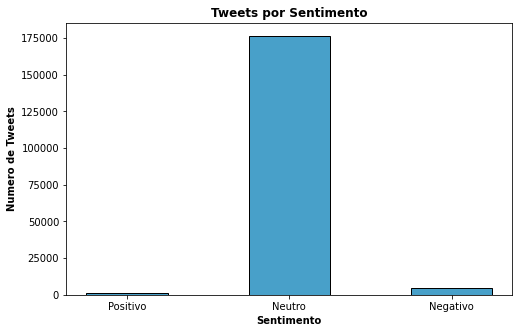

In [106]:
# Graphing the number of  tweets by sentiment
data_t = {'Positivo':positive,'Neutro':neutral,'Negativo':negative}
sentiment_t = data_t.keys()
num_tweets_t = data_t.values() 

plt.figure(figsize = (8, 5)) 

plt.bar(sentiment_t, num_tweets_t, color ='#48A0C9', width = 0.5, edgecolor='black',) 

plt.xlabel("Sentimento", fontweight ='bold') 
plt.ylabel("Numero de Tweets", fontweight ='bold') 
plt.title("Tweets por Sentimento", fontweight ='bold') 
plt.show() 

In [107]:
# Function to return a string of all words in all tweets

def get_all_tweets(df,by_sentiment=False,sentiment="positivo"):
    
    # Combine all words in tweets into a string
    if by_sentiment:
        if sentiment == "positivo":
            words = ' '.join((df.loc[df['predict']=='positivo'])['Tweet_Text'].apply(lambda x: ' '.join(x)))
        elif sentiment == "neutro":
            words = ' '.join((df.loc[df['predict']=='neutro'])['Tweet_Text'].apply(lambda x: ' '.join(x)))
        else:
            words = ' '.join((df.loc[df['predict']=='negativo'])['Tweet_Text'].apply(lambda x: ' '.join(x)))
    else:
        words = ' '.join(df['Tweet_Text'].apply(lambda x: ' '.join(x)))
        
    return words

In [108]:
# Create word strings
words = get_all_tweets(df_b)
words_pos = get_all_tweets(df_b,True,"positivo")
words_neu = get_all_tweets(df_b,True,"neutro")
words_neg= get_all_tweets(df_b,True,"negativo")



In [109]:
#funcao retorna tokens palavras
def stringToList(string):
    listRes = list(string.split(" "))
    return listRes

In [110]:
tokens = stringToList(words)
tokens_pos = stringToList(words_pos)
tokens_neu = stringToList(words_neu)
tokens_neg = stringToList(words_neg)    

In [111]:
print(pd.DataFrame(FreqDist(tokens_neg).most_common(16), columns = ["Palavra","Frequência"]))

       Palavra  Frequência
0      eleição        3947
1       brasil         796
2         povo         714
3          ano         627
4     político         603
5       querer         562
6         país         522
7        poder         518
8   brasileiro         435
9        fazer         415
10  democracia         408
11    corrupto         405
12         sim         388
13        urna         380
14       votar         367
15       golpe         360


In [112]:
# Function to plot most frquent words
def plot_word_freq(tokens,sentiment,name,color):
    fdist = FreqDist(tokens)
    fdist_df = pd.DataFrame(fdist.most_common(10), columns = ["Palavra","Frequência"])
    fig = px.bar(fdist_df, x="Palavra", y="Frequência",
                 title="<b>Palavras mais frequentes em </b>" + "<b>Tweets</b>" + " " + sentiment + " " + name )
    fig.update_traces(marker=dict(color=color),selector=dict(type="bar"),
                      marker_line_color='black', marker_line_width=1.5, opacity=0.6)
    fig.show()


In [113]:
plot_word_freq(tokens,"<b>Total</b>","<b>Tweets</b>","red")

In [114]:
plot_word_freq(tokens_pos,"<b>Positivos</b>","<b></b>","red")

In [115]:
plot_word_freq(tokens_neg,"<b>Negativos</b>","<b></b>","red")

In [116]:
plot_word_freq(tokens_neu,"<b>Neutros</b>","<b></b>","red")

In [117]:
# Function to generate word cloud
def create_wordcloud(words):
    
    # create wordcloud
    wordcloud = WordCloud(max_font_size=256, max_words=200, 
                          background_color="white",
                          collocations=False, 
                          width=2000, height=1000).generate(words)

    # display the generated image
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

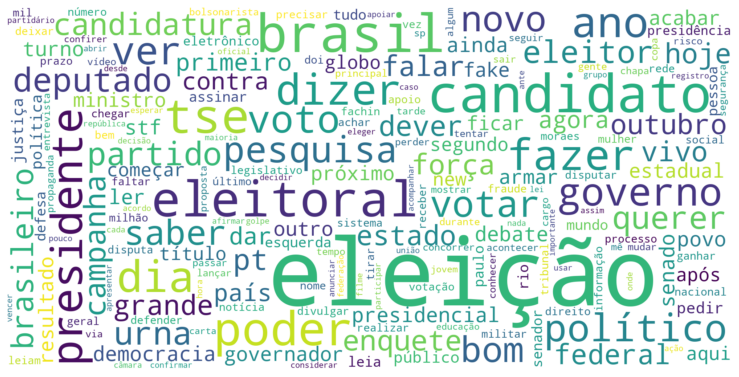

In [118]:
create_wordcloud(words)

In [119]:
#values= df_b.groupby(['User_city', 'predict'])['predict'].count()

In [120]:
#Separar valores data

def encode_dates(df, column):
    df = df.copy()
    df[column] = pd.to_datetime(df[column], format='%Y-%m-%d')
    df[column + '_year'] = df[column].apply(lambda x: x.year)
    df[column + '_month'] = df[column].apply(lambda x: x.month)
    df[column + '_day'] = df[column].apply(lambda x: x.day)
    df = df.drop(column, axis=1)
    return df


In [121]:
df_b= encode_dates(df_b, column='Date_Created')

In [122]:
df_b['User_state']= df_b['User_Location'].str.split(',',n=1, expand=True)[1]

In [123]:
df_b['User_city']= df_b['User_Location'].str.split(',',n=1, expand=True)[0]

In [124]:
df_b.head()

,Tweet_ID,Tweet_Text,Created_at,Tweet_Geo,User_Name,User_Location,Text_Final,Time_Created,predict,Date_Created_year,Date_Created_month,Date_Created_day,User_state,User_city
3,1569536492938350592,"[candidatura, indeferido, gabriel, monteiro, a...",2022-09-13 01:00:35-03:00,NaN,Jornal Extra,Brasil,"['candidatura', 'indeferido', 'gabriel', 'mont...",01:00:35,neutro,2022,9,13,None,Brasil
5,1569536352118460416,"[eleição, ver, presidenciável, jornaldarecord]",2022-09-13 01:00:01-03:00,NaN,Jornal da Record,NaN,"['eleição', 'ver', 'presidenciável', 'jornalda...",01:00:01,neutro,2022,9,13,NaN,NaN
9,1569535834680094731,"[arma, dizer, bolsonarista, ameaçar, governado...",2022-09-13 00:57:58-03:00,NaN,LinhadNoticia,NaN,"['arma', 'dizer', 'bolsonarista', 'ameaçar', '...",00:57:58,neutro,2022,9,13,NaN,NaN
10,1569534989565304832,[],2022-09-13 00:54:36-03:00,NaN,Xeulê,NaN,[],00:54:36,neutro,2022,9,13,NaN,NaN
17,1569534318061518849,"[jornalista, publicar, coluna, falar, perspect...",2022-09-13 00:51:56-03:00,NaN,Jason Bourne,NaN,"['jornalista', 'publicar', 'coluna', 'falar', ...",00:51:56,neutro,2022,9,13,NaN,NaN


In [125]:
Tweets_d= df_b.groupby([df_b['Created_at'].dt.strftime('%m-%d'), 'predict'])['Tweet_ID'].count().reset_index()

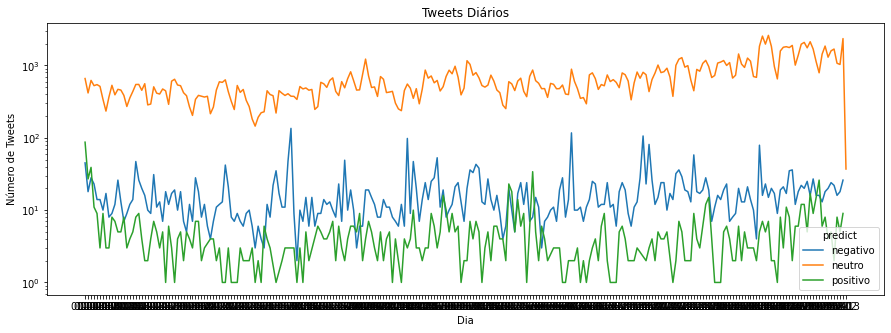

In [126]:
plt.figure(figsize=(15,5))
plot1= sns.lineplot(x = 'Created_at', y = 'Tweet_ID', hue='predict', data = Tweets_d)
plot1.set(xlabel='Dia', ylabel='Número de Tweets')
plot1. set_title('Tweets Diários')
plot1.set_yscale('log')
#plot1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000) + 'K'))

plt.show()


In [127]:
print(Tweets_d)

    Created_at   predict  Tweet_ID
0        01-01  negativo        45
1        01-01    neutro       660
2        01-01  positivo        87
3        01-02  negativo        18
4        01-02    neutro       417
..         ...       ...       ...
750      09-11  positivo         5
751      09-12  negativo        26
752      09-12    neutro      2354
753      09-12  positivo         9
754      09-13    neutro        37

[755 rows x 3 columns]


In [128]:
#Tweets_d.to_csv("eleicoes2data.csv")

In [129]:
tweets_q = df_b.groupby(df_b['Created_at'].dt.strftime('%m-%d'))['Tweet_ID'].count().reset_index()

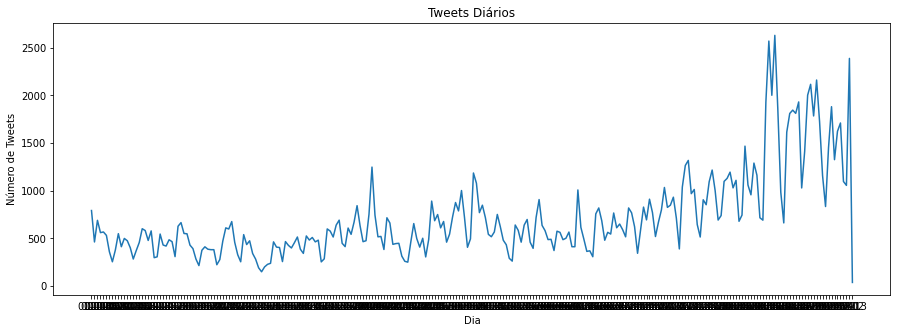

In [130]:
plt.figure(figsize=(15,5))
plot1= sns.lineplot(x = 'Created_at', y = 'Tweet_ID', data = tweets_q)
plot1.set(xlabel='Dia', ylabel='Número de Tweets')
plot1. set_title('Tweets Diários')
#plot1.set_yscale('log')
#plot1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000) + 'K'))

plt.show()

In [131]:
#tweets_q.to_csv ("tweetsdiarios.csv")

In [132]:
tweets_q

,Created_at,Tweet_ID
0,01-01,792
1,01-02,462
2,01-03,689
3,01-04,560
4,01-05,567
...,...,...
251,09-09,1711
252,09-10,1097
253,09-11,1056
254,09-12,2389


In [133]:
df_9= df_b[(df_b.Date_Created_month == 9)]


In [134]:
df_9

,Tweet_ID,Tweet_Text,Created_at,Tweet_Geo,User_Name,User_Location,Text_Final,Time_Created,predict,Date_Created_year,Date_Created_month,Date_Created_day,User_state,User_city
3,1569536492938350592,"[candidatura, indeferido, gabriel, monteiro, a...",2022-09-13 01:00:35-03:00,NaN,Jornal Extra,Brasil,"['candidatura', 'indeferido', 'gabriel', 'mont...",01:00:35,neutro,2022,9,13,None,Brasil
5,1569536352118460416,"[eleição, ver, presidenciável, jornaldarecord]",2022-09-13 01:00:01-03:00,NaN,Jornal da Record,NaN,"['eleição', 'ver', 'presidenciável', 'jornalda...",01:00:01,neutro,2022,9,13,NaN,NaN
9,1569535834680094731,"[arma, dizer, bolsonarista, ameaçar, governado...",2022-09-13 00:57:58-03:00,NaN,LinhadNoticia,NaN,"['arma', 'dizer', 'bolsonarista', 'ameaçar', '...",00:57:58,neutro,2022,9,13,NaN,NaN
10,1569534989565304832,[],2022-09-13 00:54:36-03:00,NaN,Xeulê,NaN,[],00:54:36,neutro,2022,9,13,NaN,NaN
17,1569534318061518849,"[jornalista, publicar, coluna, falar, perspect...",2022-09-13 00:51:56-03:00,NaN,Jason Bourne,NaN,"['jornalista', 'publicar', 'coluna', 'falar', ...",00:51:56,neutro,2022,9,13,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34897,1565176512755761153,"[eleição, candidato, protestar, falta, repasse...",2022-09-01 00:15:34-03:00,NaN,Roberto Notícia,NaN,"['eleição', 'candidato', 'protestar', 'falta',...",00:15:34,neutro,2022,9,1,NaN,NaN
34902,1565175163833966594,"[eleição, primeiro, voto, dar, deputado, feder...",2022-09-01 00:10:13-03:00,NaN,Claudemir Pereira,Santa Maria,"['eleição', 'primeiro', 'voto', 'dar', 'deputa...",00:10:13,neutro,2022,9,1,None,Santa Maria
34905,1565174699251978241,"[empresário, ficar, constrangir, gargalhar, es...",2022-09-01 00:08:22-03:00,NaN,Alessandra Fernandes,NaN,"['empresário', 'ficar', 'constrangir', 'gargal...",00:08:22,neutro,2022,9,1,NaN,NaN
34912,1565173832012517382,"[brumar, verdade, mundo, gira, revelar, verdad...",2022-09-01 00:04:55-03:00,NaN,Nildo de Freitas,Brasil,"['brumar', 'verdade', 'mundo', 'gira', 'revela...",00:04:55,negativo,2022,9,1,None,Brasil
